In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import joblib
import numpy as np

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("game_features_raw4.csv")

# -------------------------
# Columns to drop
# -------------------------
cols_to_drop = [
    "season",
    "game_id",
    "game_date",
    "team_id",
    "team_name",
    "opponent_team_id",
    "opponent_team_name",
    "game_index"
]

# -------------------------
# Train-test split by season
# -------------------------
train_seasons = ['2020-21', '2021-22', '2022-23', '2023-24']
test_season = '2024-25'

train_df = df[df["season"].isin(train_seasons)].copy()
test_df = df[df["season"] == test_season].copy()

# Drop unwanted columns
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# Split into X/y
X_train = train_df.drop(columns=["win"])
y_train = train_df["win"]

X_test = test_df.drop(columns=["win"])
y_test = test_df["win"]

# -------------------------
# Train Random Forest
# -------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# -------------------------
# Feature importance
# -------------------------
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("====================================")
print("Feature Importances (Top Features)")
print("====================================")
print(feature_importance_df)

# Optionally, select top N features
top_features = feature_importance_df[feature_importance_df["importance"] > 0.01]["feature"]
print("\nSelected top features (>1% importance):")
print(top_features.tolist())

# -------------------------
# Evaluate on test set
# -------------------------
y_pred = rf.predict(X_test)

print("\n====================================")
print("Random Forest Performance on 2024-25 Season")
print("====================================")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Feature Importances (Top Features)
                      feature  importance
113    matchup_net_rating_gap    0.024334
117  pace_adjusted_net_rating    0.023384
114       matchup_win_pct_gap    0.020213
111  opp_netRating_avg_todate    0.016340
115           matchup_PPP_gap    0.014875
..                        ...         ...
48                  win_last7    0.002968
110      days_since_last_game    0.002649
47                  win_last5    0.002343
46                  win_last3    0.001655
109      eFG_pace_interaction    0.000000

[121 rows x 2 columns]

Selected top features (>1% importance):
['matchup_net_rating_gap', 'pace_adjusted_net_rating', 'matchup_win_pct_gap', 'opp_netRating_avg_todate', 'matchup_PPP_gap', 'opp_win_pct_todate', 'PPP_diff_avg_todate', 'opp_PPP_avg_todate', 'team_netRating_avg_todate', 'eFG_diff_avg_todate']

Random Forest Performance on 2024-25 Season
Accuracy: 0.6434563758389261

Classification Report:
              precision    recall  f1-score   support


In [ ]:
import pandas as pd
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
import joblib

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("game_features_raw2.csv")

# -------------------------
# Columns to drop
# -------------------------
cols_to_drop = [
    "season",
    "game_id",
    "game_date",
    "team_id",
    "team_name",
    "opponent_team_id",
    "opponent_team_name",
    "game_index"
]

# -------------------------
# Train-test split by season
# -------------------------
train_seasons = ['2020-21', '2021-22', '2022-23', '2023-24']
test_season = '2024-25'

train_df = df[df["season"].isin(train_seasons)].copy()
test_df = df[df["season"] == test_season].copy()

# -------------------------
# Drop unwanted columns
# -------------------------
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# -------------------------
# Split into X/y
# -------------------------
X_train = train_df.drop(columns=["win"])
y_train = train_df["win"]

X_test = test_df.drop(columns=["win"])
y_test = test_df["win"]

# -------------------------
# Base model
# -------------------------
logreg = LogisticRegression(max_iter=500, solver="lbfgs")

# -------------------------
# RFECV: Recursive Feature Elimination with cross-validation
# Automatically finds optimal # of features
# -------------------------
rfecv = RFECV(
    estimator=logreg,
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    n_jobs=-1
)

# Scale before RFECV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit RFECV
rfecv.fit(X_train_scaled, y_train)

# -------------------------
# Selected features output
# -------------------------
selected_features = X_train.columns[rfecv.support_]

print("====================================")
print("Selected Features by RFECV:")
print("====================================")
for feat in selected_features:
    print(" -", feat)

print("\nOptimal number of features chosen:", rfecv.n_features_)

# -------------------------
# Train final Logistic Regression on selected features
# -------------------------
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500, solver="lbfgs"))
])

final_pipeline.fit(X_train[selected_features], y_train)

# -------------------------
# Evaluate
# -------------------------
y_pred = final_pipeline.predict(X_test[selected_features])

print("\n====================================")
print("Model Performance on 2024-25 Season")
print("====================================")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Selected Features by RFECV:
 - home
 - team_netRating_avg_todate
 - TOV_diff_avg_todate
 - ORB_diff_avg_todate
 - PPP_diff_avg_todate
 - DRB_diff_avg_todate
 - TRB_diff_avg_todate
 - TOV_diff_last5
 - points_off_turnovers_pct_diff_last3
 - points_off_turnovers_pct_diff_last5
 - turnover_rate_adjusted
 - opp_netRating_avg_todate
 - matchup_net_rating_gap
 - matchup_win_pct_gap
 - pace_adjusted_net_rating
 - home.1

Optimal number of features chosen: 16

Model Performance on 2024-25 Season
Accuracy: 0.662751677852349

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1192
           1       0.66      0.67      0.66      1192

    accuracy                           0.66      2384
   macro avg       0.66      0.66      0.66      2384
weighted avg       0.66      0.66      0.66      2384



In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import numpy as np

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("game_features_raw4.csv")

# -------------------------
# Columns to drop
# -------------------------
cols_to_drop = [
    "season",
    "game_id",
    "game_date",
    "team_id",
    "team_name",
    "opponent_team_id",
    "opponent_team_name",
    "game_index"
]

# -------------------------
# Train-test split by season
# -------------------------
train_seasons = ['2020-21', '2021-22', '2022-23', '2023-24']
test_season = '2024-25'

train_df = df[df["season"].isin(train_seasons)].copy()
test_df = df[df["season"] == test_season].copy()

# Drop unwanted columns
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# -------------------------
# Split into X/y
# -------------------------
X_train = train_df.drop(columns=["win"])
y_train = train_df["win"]

X_test = test_df.drop(columns=["win"])
y_test = test_df["win"]

# -------------------------
# Train XGBoost classifier
# -------------------------
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)

# -------------------------
# Feature importance
# -------------------------
importances = xgb.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("====================================")
print("Feature Importances (Top Features)")
print("====================================")
print(feature_importance_df)

# Optionally select features above threshold
top_features = feature_importance_df[feature_importance_df["importance"] > 0.01]["feature"]
print("\nSelected top features (>1% importance):")
print(top_features.tolist())

# -------------------------
# Evaluate on test set
# -------------------------
y_pred = xgb.predict(X_test)

print("\n====================================")
print("XGBoost Performance on 2024-25 Season")
print("====================================")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:58:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Feature Importances (Top Features)
                      feature  importance
117  pace_adjusted_net_rating    0.044243
113    matchup_net_rating_gap    0.029086
119                    home.1    0.025826
0                        home    0.019082
114       matchup_win_pct_gap    0.017811
..                        ...         ...
54             team_PPP_last3    0.006413
65            DRB_diff_last10    0.006326
42            team_pace_last3    0.006086
61            PPP_diff_last10    0.005665
109      eFG_pace_interaction    0.000000

[121 rows x 2 columns]

Selected top features (>1% importance):
['pace_adjusted_net_rating', 'matchup_net_rating_gap', 'home.1', 'home', 'matchup_win_pct_gap', 'days_since_last_game', 'game_index.1', 'team_netRating_avg_todate']

XGBoost Performance on 2024-25 Season
Accuracy: 0.6304530201342282

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1192
           1       0.63      0

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import joblib

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("game_features_raw2.csv")

# -------------------------
# Columns to drop
# -------------------------
cols_to_drop = [
    "season",
    "game_id",
    "game_date",
    "team_id",
    "team_name",
    "opponent_team_id",
    "opponent_team_name",
    "game_index"
]

# -------------------------
# Train-test split by season
# -------------------------
train_seasons = ['2020-21', '2021-22', '2022-23', '2023-24']
test_season = '2024-25'

train_df = df[df["season"].isin(train_seasons)].copy()
test_df = df[df["season"] == test_season].copy()

# -------------------------
# Drop unwanted columns
# -------------------------
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# -------------------------
# Split into X/y
# -------------------------
X_train = train_df.drop(columns=["win"])
y_train = train_df["win"]

X_test = test_df.drop(columns=["win"])
y_test = test_df["win"]

# -------------------------
# Base model for RFECV
# -------------------------
logreg = LogisticRegression(max_iter=500, solver="lbfgs")

# -------------------------
# RFECV: Recursive Feature Elimination with CV
# -------------------------
rfecv = RFECV(
    estimator=logreg,
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    n_jobs=-1
)

# Scale before RFECV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit RFECV
rfecv.fit(X_train_scaled, y_train)

# -------------------------
# Selected features output
# -------------------------
selected_features = X_train.columns[rfecv.support_]

print("====================================")
print("Selected Features by RFECV:")
print("====================================")
for feat in selected_features:
    print(" -", feat)

print("\nOptimal number of features chosen:", rfecv.n_features_)

# -------------------------
# Hyperparameter Tuning: GridSearchCV
# -------------------------
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500))
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1, 2, 5, 10, 100],
    "logreg__penalty": ["l2"],  # lbfgs supports only l2
    "logreg__solver": ["lbfgs", "saga"]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    n_jobs=-1
)

# Fit GridSearch on selected features
grid_search.fit(X_train[selected_features], y_train)

print("\n====================================")
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# -------------------------
# Evaluate on Test Set
# -------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[selected_features])

print("\n====================================")
print("Model Performance on 2024-25 Season")
print("====================================")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the final tuned model
model_filename = "logreg_final_model.pkl"
joblib.dump(best_model, model_filename)
print(f"\nFinal model saved to: {model_filename}")


Selected Features by RFECV:
 - home
 - team_defensiveRating_avg_todate
 - team_netRating_avg_todate
 - opp_PPP_avg_todate
 - PPP_diff_avg_todate
 - DRB_diff_avg_todate
 - team_netRating_last7
 - eFG_diff_last5
 - ORB_diff_last5
 - TRB_diff_last5
 - opp_netRating_avg_todate
 - matchup_net_rating_gap
 - matchup_win_pct_gap
 - off_vs_def_rating
 - pace_adjusted_net_rating
 - home.1

Optimal number of features chosen: 16

Best Hyperparameters from GridSearchCV:
{'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best CV Accuracy: 0.632407549254452

Model Performance on 2024-25 Season
Accuracy: 0.6656879194630873

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1192
           1       0.66      0.67      0.67      1192

    accuracy                           0.67      2384
   macro avg       0.67      0.67      0.67      2384
weighted avg       0.67      0.67      0.67      2384


Final model save

Creating sequences...
Sequence length: 10 games

Training sequences: (8982, 10, 87)
Test sequences: (2084, 10, 87)

Building RNN Model


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        38,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,873 (202.63 KB)

 Trainable params: 51,873 (202.63 KB)

 Non-trainable params: 0 (0.00 B)


Training RNN Model
Epoch 1/100
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5460 - loss: 0.6868
Epoch 1: val_accuracy improved from -inf to 0.60323, saving model to best_rnn_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5463 - loss: 0.6867 - val_accuracy: 0.6032 - val_loss: 0.6637
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5886 - loss: 0.6720
Epoch 2: val_accuracy improved from 0.60323 to 0.60879, saving model to best_rnn_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5886 - loss: 0.6720 - val_accuracy: 0.6088 - val_loss: 0.6667
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5762 - loss: 0.6721
Epoch 3: val_accuracy did not improve from 0.60879
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5762 - loss: 0.6721 - val_accuracy: 0.5748 - val_loss: 0.6653
Epoch 4/100
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5983 - loss: 0.6655
Epoch 4: val_accuracy did not improve f

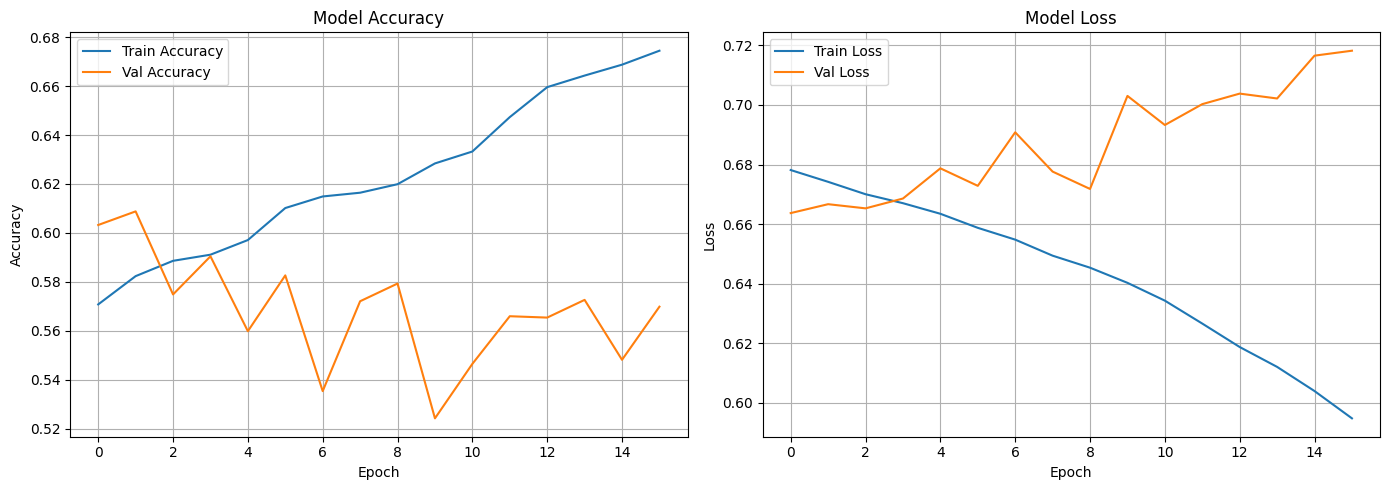


Training Complete!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("game_features_raw2.csv")

# -------------------------
# Columns to drop
# -------------------------
cols_to_drop = [
    "season",
    "game_id",
    "game_date",
    "opponent_team_id",
    "opponent_team_name",
    "game_index"
]

# -------------------------
# Train-test split by season
# -------------------------
train_seasons = ['2020-21', '2021-22', '2022-23', '2023-24']
test_season = '2024-25'

train_df = df[df["season"].isin(train_seasons)].copy()
test_df = df[df["season"] == test_season].copy()

# -------------------------
# Prepare sequences by team
# -------------------------
def create_sequences(data, seq_length=10):
    """
    Create sequences of games for each team.
    seq_length: number of previous games to use as input
    """
    sequences = []
    labels = []

    # Group by team
    for team_id in data["team_id"].unique():
        team_data = data[data["team_id"] == team_id].sort_values("game_date")

        # Drop metadata columns but keep team info for grouping
        feature_cols = [col for col in team_data.columns
                       if col not in cols_to_drop + ["win", "team_id", "team_name"]]

        team_features = team_data[feature_cols].values
        team_labels = team_data["win"].values

        # Create sequences
        for i in range(len(team_features) - seq_length):
            sequences.append(team_features[i:i+seq_length])
            labels.append(team_labels[i+seq_length])

    return np.array(sequences), np.array(labels)

# -------------------------
# Hyperparameters
# -------------------------
SEQUENCE_LENGTH = 10  # Use last 10 games to predict next game
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

print("Creating sequences...")
print(f"Sequence length: {SEQUENCE_LENGTH} games")

# Create sequences
X_train_seq, y_train = create_sequences(train_df, SEQUENCE_LENGTH)
X_test_seq, y_test = create_sequences(test_df, SEQUENCE_LENGTH)

print(f"\nTraining sequences: {X_train_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")

# -------------------------
# Scale features
# -------------------------
# Reshape for scaling: (samples * timesteps, features)
n_samples, n_timesteps, n_features = X_train_seq.shape

X_train_reshaped = X_train_seq.reshape(-1, n_features)
X_test_reshaped = X_test_seq.reshape(-1, n_features)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to sequences
X_train_scaled = X_train_scaled.reshape(n_samples, n_timesteps, n_features)
X_test_scaled = X_test_scaled.reshape(X_test_seq.shape[0], n_timesteps, n_features)

# -------------------------
# Build RNN Model
# -------------------------
print("\n====================================")
print("Building RNN Model")
print("====================================")

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_timesteps, n_features)),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -------------------------
# Callbacks
# -------------------------
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_rnn_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# -------------------------
# Train Model
# -------------------------
print("\n====================================")
print("Training RNN Model")
print("====================================")

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# -------------------------
# Evaluate on Test Set
# -------------------------
print("\n====================================")
print("Model Performance on 2024-25 Season")
print("====================================")

y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# -------------------------
# Save Model and Scaler
# -------------------------
model.save("rnn_final_model.keras")
joblib.dump(scaler, "rnn_scaler.pkl")

print(f"\nFinal model saved to: rnn_final_model.keras")
print(f"Scaler saved to: rnn_scaler.pkl")

# -------------------------
# Plot Training History
# -------------------------
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\n====================================")
print("Training Complete!")
print("====================================")

Training samples: 9282
Test samples: 2384
Number of features: 87

Training Base XGBoost Model
Base Model Test Accuracy: 0.6098993288590604
Base Model AUC-ROC: 0.6572648754560606

Top 20 Most Important Features:
                        feature  importance
       pace_adjusted_net_rating    0.132087
                           home    0.023150
            matchup_win_pct_gap    0.015652
            DRB_diff_avg_todate    0.015638
                 PPP_diff_last5    0.015431
                   game_index.1    0.013215
      team_netRating_avg_todate    0.013208
                 PPP_diff_last3    0.013040
       opp_netRating_avg_todate    0.012807
             opp_win_pct_todate    0.012075
                     win_last10    0.011904
                 DRB_diff_last5    0.011754
                 DRB_diff_last3    0.011337
                TRB_diff_last10    0.011263
                team_pace_last7    0.011228
                      win_last3    0.011175
                TOV_diff_last10    0.0110

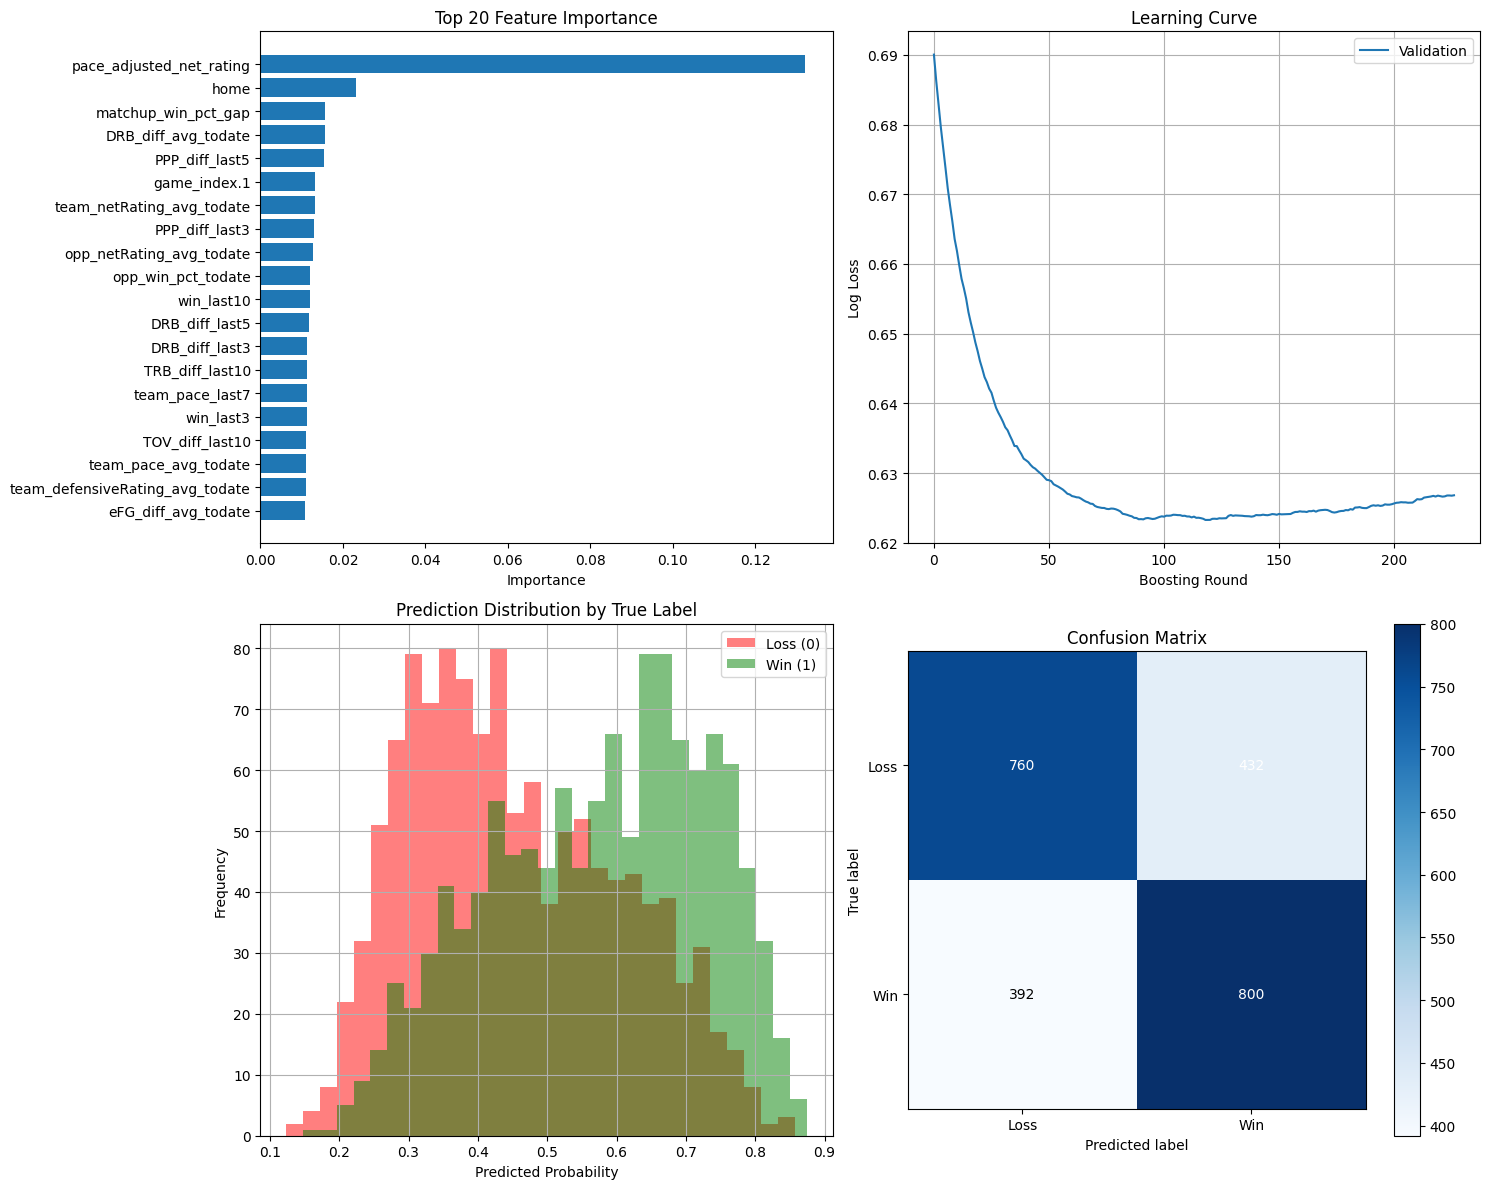


Training Complete!
Results visualizations saved to: xgboost_results.png


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("game_features_raw2.csv")

# -------------------------
# Columns to drop
# -------------------------
cols_to_drop = [
    "season",
    "game_id",
    "game_date",
    "team_id",
    "team_name",
    "opponent_team_id",
    "opponent_team_name",
    "game_index"
]

# -------------------------
# Train-test split by season
# -------------------------
train_seasons = ['2020-21', '2021-22', '2022-23', '2023-24']
test_season = '2024-25'

train_df = df[df["season"].isin(train_seasons)].copy()
test_df = df[df["season"] == test_season].copy()

# -------------------------
# Drop unwanted columns
# -------------------------
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# -------------------------
# Split into X/y
# -------------------------
X_train = train_df.drop(columns=["win"])
y_train = train_df["win"]

X_test = test_df.drop(columns=["win"])
y_test = test_df["win"]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {len(X_train.columns)}")

# -------------------------
# Base XGBoost Model
# -------------------------
print("\n====================================")
print("Training Base XGBoost Model")
print("====================================")

base_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Train with evaluation set
base_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Base model predictions
y_pred_base = base_model.predict(X_test)
y_pred_proba_base = base_model.predict_proba(X_test)[:, 1]

print("Base Model Test Accuracy:", accuracy_score(y_test, y_pred_base))
print("Base Model AUC-ROC:", roc_auc_score(y_test, y_pred_proba_base))

# -------------------------
# Feature Importance
# -------------------------
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': base_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n====================================")
print("Top 20 Most Important Features:")
print("====================================")
print(feature_importance.head(20).to_string(index=False))

# -------------------------
# Hyperparameter Tuning: RandomizedSearchCV
# -------------------------
print("\n====================================")
print("Hyperparameter Tuning with RandomizedSearchCV")
print("====================================")

from scipy.stats import uniform, randint

param_distributions = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.29),  # uniform between 0.01 and 0.3
    'n_estimators': randint(100, 500),
    'min_child_weight': randint(1, 7),
    'subsample': uniform(0.6, 0.4),  # uniform between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # uniform between 0.6 and 1.0
    'gamma': uniform(0, 0.5),  # uniform between 0 and 0.5
    'reg_alpha': uniform(0, 1),  # L1 regularization
    'reg_lambda': uniform(1, 2)  # L2 regularization (1 to 3)
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings to sample
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Running RandomizedSearchCV with 100 iterations...")
random_search.fit(X_train, y_train)

print("\n====================================")
print("Best Hyperparameters from RandomizedSearchCV:")
print("====================================")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Accuracy: {random_search.best_score_:.4f}")

# -------------------------
# Train Final Model with Best Parameters
# -------------------------
print("\n====================================")
print("Training Final Model with Best Parameters")
print("====================================")

best_model = random_search.best_estimator_

# Train with early stopping on validation set
X_train_split = X_train.iloc[:int(0.8*len(X_train))]
y_train_split = y_train.iloc[:int(0.8*len(y_train))]
X_val_split = X_train.iloc[int(0.8*len(X_train)):]
y_val_split = y_train.iloc[int(0.8*len(y_train)):]

best_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=False
)

# -------------------------
# Evaluate on Test Set
# -------------------------
print("\n====================================")
print("Model Performance on 2024-25 Season")
print("====================================")

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# -------------------------
# Save Model
# -------------------------
model_filename = "xgboost_final_model.pkl"
joblib.dump(best_model, model_filename)
print(f"\nFinal model saved to: {model_filename}")

# -------------------------
# Visualizations
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance (Top 20)
top_features = feature_importance.head(20)
axes[0, 0].barh(top_features['feature'], top_features['importance'])
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Top 20 Feature Importance')
axes[0, 0].invert_yaxis()

# 2. Learning Curves
results = best_model.evals_result()
if results:
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    axes[0, 1].plot(x_axis, results['validation_0']['logloss'], label='Validation')
    axes[0, 1].set_xlabel('Boosting Round')
    axes[0, 1].set_ylabel('Log Loss')
    axes[0, 1].set_title('Learning Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

# 3. Prediction Distribution
axes[1, 0].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.5, label='Loss (0)', color='red')
axes[1, 0].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.5, label='Win (1)', color='green')
axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Prediction Distribution by True Label')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 4. Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
im = axes[1, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1, 1].set_title('Confusion Matrix')
plt.colorbar(im, ax=axes[1, 1])
tick_marks = np.arange(2)
axes[1, 1].set_xticks(tick_marks)
axes[1, 1].set_yticks(tick_marks)
axes[1, 1].set_xticklabels(['Loss', 'Win'])
axes[1, 1].set_yticklabels(['Loss', 'Win'])
axes[1, 1].set_ylabel('True label')
axes[1, 1].set_xlabel('Predicted label')

# Add text annotations to confusion matrix
for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.savefig('xgboost_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n====================================")
print("Training Complete!")
print("Results visualizations saved to: xgboost_results.png")
print("====================================")